# Test suite for Project 1


In [89]:
from proj1_helpers import *
from implementations import *
from auxiliary import *
import pickle
import matplotlib.pyplot as plt
import datetime

%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Data loading

* `../data/train.csv`
* `../data/test.csv`


In [5]:
train_path = '../data/train.csv'
test_path  = '../data/test.csv'

In [6]:
# Long, run only if necessary
train_data = load_csv_data(train_path)

In [7]:
# Long, run only if necessary
test_data = load_csv_data(test_path)

In [91]:
# Save the data as pickles for more efficient reloading
# Only run once to generate the pickle !
# pickle.dump(test_data, open( 'test.p', 'wb' ))
# pickle.dump(train_data, open( 'train.p', 'wb' ))

In [113]:
# loading the pickle back 
# train_data = pickle.load(open( 'train.p', 'rb' ))
# test_data = pickle.load(open( 'test.p', 'rb' ))

## Exploratory

* Describe / Discover the data
* Describe / Characterise the features

In [92]:
## Data dimensions
print("There are {} samples.".format(len(train_data[0])))

There are 250000 samples.


The training data is defined as a set $D = \{ (y_i, \mathbf{x}_i, w_i) \}$ with :
* $y_i \in \{+1,-1\}$ is the label (signal = `+1` or noise = `-1`)
* $\mathbf{x}_i \in \!R^d$ is a $d$-dimensional feature vector
* $w_i \in \!R^+$ is a non-negative weight

Note that $\sum_{i\in\mathcal{S}} w_i = N_s$ and $\sum_{i\in\mathcal{B}} w_i = N_b$ which are the *expected total number of signal and background events (resp.)*. This gives an estimate of how many events we should expect to classify for each class.

In [93]:
# The feature vector shape is 
train_data[2].shape

(250000, 30)

In [8]:
# Which means we have d features :
d = train_data[2].shape[1]
d

30

In [122]:
ids = train_data[0]
labels  = train_data[1]
x_train = train_data[2]

if(labels.ndim<2):
    labels = np.expand_dims(labels, axis=1) # expand the labels as array

In [126]:
test_ids = train_data[0]
test_labels  = train_data[1]
test_x = train_data[2]

if(test_labels.ndim<2):
    test_labels = np.expand_dims(test_labels, axis=1) # expand the labels as array

Information about the features :

* Variables are floating point unless specified otherwise.
* All azimuthal φ angles are in radian in the [−π, +π[ range.
* Energy, mass, momentum are all in GeV
* All other variables are unit less
* **Undefined values are `-999.0`**

There are `primitive` (prefixed with `PRI`) values, directly measured from the collision, and `derived` (prefixed with `DER`) values which were computed from the primitive values.

In [21]:
PRI_features = x_train[:,:13]
DER_features = x_train[:,13:]
print(len(PRI_features[0]), len(DER_features[0]))

13 17


## Data processing

* Split test / train
* Clean useless features
* [Scale / process data](https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/) (e.g. scaling)

How much data is perfectly clean ?

In [11]:
clean_data = [x for x in x_train if not -999. in x]
len(clean_data)/len(x_train)*100 # percent

27.245599999999996

How much data is clean in the primitive or derived classes ?

In [12]:
PRI_clean_data = [x for x in PRI_features if not -999. in x]
len(PRI_clean_data)/len(PRI_features)*100 # percent

27.245599999999996

In [13]:
DER_clean_data = [x for x in DER_features if not -999. in x]
len(DER_clean_data)/len(DER_features)*100 # percent

29.0172

The percentage is almost the same ! This means there was not a lot of treatment error, using only `PRI` or only `DER` data won't make the data cleaner (but it might help reduce the complexity of the model ;) )

Are there classes that contain a high probability of dirty data ?

In [14]:
per_feature_stats = []
for i in range(d):
    sz = len(x_train[:,i])
    clean_ft = [x for x in x_train[:,i] if (x != -999.)] # c pa bo ... :'(
    per_feature_stats.append(len(clean_ft) / sz * 100)

(array([  7.,   0.,   0.,   0.,   3.,   0.,   0.,   1.,   0.,  19.]),
 array([  29.0172 ,   36.11548,   43.21376,   50.31204,   57.41032,
          64.5086 ,   71.60688,   78.70516,   85.80344,   92.90172,  100.     ]),
 <a list of 10 Patch objects>)

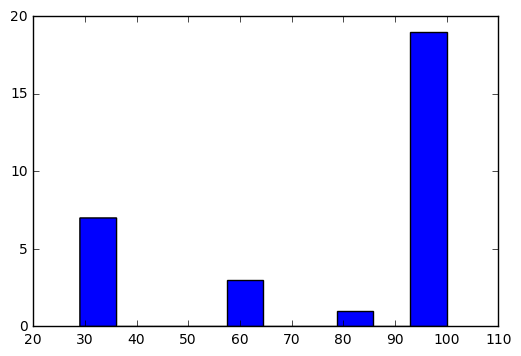

In [35]:
plt.hist(per_feature_stats)

This gives a pretty good indication of the features that should be pruned from the data ! Notably :
* `x_train[:, 4: 7]` (which are resp. `DER_deltaeta_jet_jet`, `DER_mass_jet_jet`, `DER_prodeta_jet_jet`)
* `x_train[:,12]` (which is `DER_lep_eta_centrality`)
* `x_train[:,26:29]` (which is the `PRI_jet_subleading_{pt,eta,phi}`)

We can also consider removing `x_train[:,23:26]` (`PRI_jet_leading_{pt,eta,phi}`) which only has ~60% clean data ...

In [17]:
# Only 100% clean data
ranges = [(1,4), (7,12), (13,23), (29,30)]
keep_idx = build_idx(ranges)
x_train_full_clean = x_train[:,keep_idx]

In [18]:
# With feature 1 and 23-26
ranges = [(0,4), (7,12), (13,26), (29,30)]
keep_idx = build_idx(ranges)
x_train_partial_clean = x_train[:,keep_idx]

In [19]:
# With features 1-3
ranges = [(1,4)]
keep_idx = build_idx(ranges)
x_train_small_features = x_train[:,keep_idx]

Check the size of the sets, and expand the sets

In [23]:
print(x_train.shape)
print(x_train_full_clean.shape)
print(x_train_partial_clean.shape)
print(x_train_small_features.shape)

tx_train = np.c_[np.ones((labels.shape[0], 1)), x_train]
tx_train_full_clean = np.c_[np.ones((labels.shape[0], 1)), x_train_full_clean]
tx_train_partial_clean = np.c_[np.ones((labels.shape[0], 1)), x_train_partial_clean]
tx_train_small_features = np.c_[np.ones((labels.shape[0], 1)), x_train_small_features]

(250000, 30)
(250000, 19)
(250000, 23)
(250000, 3)


Create a very small set for testing the algorithms

In [99]:
# Needs to be randomly sampled !
sample_small_set = 1000

small_tx_train = tx_train_full_clean[:sample_small_set, :]
small_labels = labels[:sample_small_set].flatten()

dim = small_tx_train.shape[1]


Scale the training data

In [106]:
small_tx_std, mean_tx, std_tx = standardize(small_tx_train)

In [116]:
mean_tx, std_tx, np.mean(small_tx_std), np.std(small_tx_std)

(38.333962050000004, 73.500211504812071, -5.6843418860808016e-17, 1.0)

Create some testing data

In [215]:
subset_x_test_full_clean = test_x[sample_small_set:2*sample_small_set,:]
subset_test_labels = test_labels[sample_small_set:2*sample_small_set].flatten()

In [216]:
small_test_x_std, mean_test_x, std_test_x = standardize(small_tx_train)

## Training

* **Train** the model with the different learning algorithms
    * `least_squares`
    * `least_squares_GD`
    * `least_squares_SGD`
    * `ridge_regression`
    * `logistic_regression`
    * `reg_logistic_regression`

#### Least squares

In [217]:
# grid search is much too long, least_squares sucks ...
# grid_w = generate_w(dim=dim,num_intervals=10, upper=100, lower=-100)

#### Least Squares with Gradient Descent

In [218]:
w_initial = np.array([0]*dim)
max_iters = 100
gammas = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
losses = []
ws = [] 

for gamma in gammas:
    w, loss = least_squares_GD(small_labels, small_tx_std, w_initial, max_iters, gamma)
    losses.append(loss)
    ws.append(w)

# TODO : Formally get best params. In this case 1e-9 is the best so we'll see later

In [219]:
losses

[0.5000000611911537,
 0.50000061191767431,
 0.5000061197905592,
 0.50006125934938073,
 0.50061880056390395,
 0.50687675941004973,
 0.82414554752788527,
 187101287673.21201]

Predict a few values to check the test accuracy :

In [220]:
accuracy = compute_classification_error(subset_test_labels, small_test_x_std, ws[0])
print("method -- Least Squares GD")
print("params -- gamma = {}, max_iters = {}".format(gammas[0], max_iters))
print()
print("On a simple subset we obtain %.2f percent accuracy" % (accuracy*100))

method -- Least Squares GD
params -- gamma = 1e-09, max_iters = 100

On a simple subset we obtain 68.30 percent accuracy


#### least_squares_SGD

Comments : Same results as `least_square_GD`

In [221]:
# Define the parameters of the algorithm.
max_iters = 100
gammas = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
batch_size = 10

# Initialization
w_initial = np.array([0]*dim)
losses = []
ws = [] 

for gamma in gammas:
    sgd_ws, sgd_losses = least_squares_SGD(small_labels, small_tx_std, w_initial, batch_size, max_iters, gamma)
    losses.append(sgd_losses)
    ws.append(sgd_ws)

In [222]:
losses

[0.50000012979479314,
 0.50000015936171738,
 0.50000256482307859,
 0.50010230278493528,
 0.50165870755937725,
 0.52030280771213011,
 0.95860061294089272,
 51596308359.381584]

In [223]:
accuracy = compute_classification_error(subset_test_labels, small_test_x_std, ws[0])
print("method -- Least Squares SGD")
print("params -- gamma = {}, max_iters = {}".format(gammas[0], max_iters))
print()
print("On a simple subset we obtain %.2f percent accuracy" % (accuracy*100))

method -- Least Squares SGD
params -- gamma = 1e-09, max_iters = 100

On a simple subset we obtain 68.30 percent accuracy


#### ridge_regression

**TODO**

In [226]:
lambdas = np.logspace(-10, 0, 15)

rmse_tr = []
rmse_te = []

ws = []
    
for ind, lambda_ in enumerate(lambdas):
    weights, loss = ridge_regression(small_labels, small_tx_std, lambda_)
    
    ws.append(weights)
    
    pred_train = small_tx_std.dot(weights)
    pred_test  = small_test_x_std.dot(weights)

    rmse_tr.append(np.sqrt(2*((pred_train-small_labels)**2).mean()))
    rmse_te.append(np.sqrt(2*((pred_test -subset_test_labels)**2) .mean()))
        
    print("lambda={l:.5f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
           l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        

lambda=0.00000, Training RMSE=1.185, Testing RMSE=1.498
lambda=0.00000, Training RMSE=1.185, Testing RMSE=1.498
lambda=0.00000, Training RMSE=1.185, Testing RMSE=1.498
lambda=0.00000, Training RMSE=1.185, Testing RMSE=1.498
lambda=0.00000, Training RMSE=1.185, Testing RMSE=1.497
lambda=0.00000, Training RMSE=1.185, Testing RMSE=1.496
lambda=0.00000, Training RMSE=1.186, Testing RMSE=1.489
lambda=0.00001, Training RMSE=1.193, Testing RMSE=1.471
lambda=0.00005, Training RMSE=1.211, Testing RMSE=1.449
lambda=0.00027, Training RMSE=1.229, Testing RMSE=1.433
lambda=0.00139, Training RMSE=1.238, Testing RMSE=1.424
lambda=0.00720, Training RMSE=1.242, Testing RMSE=1.412
lambda=0.03728, Training RMSE=1.252, Testing RMSE=1.380
lambda=0.19307, Training RMSE=1.287, Testing RMSE=1.343
lambda=1.00000, Training RMSE=1.332, Testing RMSE=1.339


In [228]:
accuracy = compute_classification_error(subset_test_labels, small_test_x_std, ws[9])
print("method -- Ridge regression")
print("params -- lambda = {}, max_iters = {}".format(lambdas[9], max_iters))
print()
print("On a simple subset we obtain %.2f percent accuracy" % (accuracy*100))

method -- Ridge regression
params -- lambda = 0.0002682695795279727, max_iters = 100

On a simple subset we obtain 40.80 percent accuracy


Not great accuracy at all ... Let's check with some polynomial dimensions added :

In [272]:
lambdas = np.logspace(-10, 0, 15)
degree = 10

poly_train = np.asarray(build_poly(small_tx_std, degree))
poly_test  = np.asarray(build_poly(small_test_x_std, degree))

rmse_tr = []
rmse_te = []

ws = []

for ind, lambda_ in enumerate(lambdas):
    weights, loss = ridge_regression(small_labels, poly_train, lambda_)
    
    ws.append(weights)
    
    pred_train = poly_train.dot(weights)
    pred_test  = poly_test.dot(weights)

    rmse_tr.append(np.sqrt(2*((pred_train-small_labels)**2).mean()))
    rmse_te.append(np.sqrt(2*((pred_test -subset_test_labels)**2).mean()))
        
    print("degree={d}, lambda={l:.5f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
           d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))

degree=10, lambda=0.00000, Training RMSE=1.073, Testing RMSE=1.634
degree=10, lambda=0.00000, Training RMSE=1.035, Testing RMSE=1.604
degree=10, lambda=0.00000, Training RMSE=1.033, Testing RMSE=1.602
degree=10, lambda=0.00000, Training RMSE=1.060, Testing RMSE=1.619
degree=10, lambda=0.00000, Training RMSE=1.166, Testing RMSE=1.668
degree=10, lambda=0.00000, Training RMSE=1.044, Testing RMSE=1.589
degree=10, lambda=0.00000, Training RMSE=1.073, Testing RMSE=1.620
degree=10, lambda=0.00001, Training RMSE=1.053, Testing RMSE=1.575
degree=10, lambda=0.00005, Training RMSE=1.051, Testing RMSE=1.580
degree=10, lambda=0.00027, Training RMSE=1.053, Testing RMSE=1.576
degree=10, lambda=0.00139, Training RMSE=1.059, Testing RMSE=1.569
degree=10, lambda=0.00720, Training RMSE=1.067, Testing RMSE=1.563
degree=10, lambda=0.03728, Training RMSE=1.078, Testing RMSE=1.555
degree=10, lambda=0.19307, Training RMSE=1.094, Testing RMSE=1.542
degree=10, lambda=1.00000, Training RMSE=1.109, Testing RMSE=1

In [281]:
accuracy = compute_classification_error(subset_test_labels, poly_test, ws[2])
print("method -- Ridge regression with poly")
print("params -- lambda = {}, degree = {}".format(lambdas[2], degree))
print()
print("On a simple subset we obtain %.2f percent accuracy" % (accuracy*100))

method -- Ridge regression with poly
params -- lambda = 2.6826957952797275e-09, degree = 10

On a simple subset we obtain 45.30 percent accuracy


#### logistic_regression

**TODO**

#### reg_logistic_regression

**TODO**

In [30]:
# TODO Check impl, there's a problem here
def cross_validation(y, tx, k_indices, k, lambda_):
    """return the loss of logistic regression."""
    # get k'th subgroup in test, others in train
    k_indices = k_indices.astype(int)
    k_indices_train = np.array([])
    
    for i in range(k_indices.shape[0]):
        if i != k:
            k_indices_train = np.append(k_indices_train, k_indices[i])
    
    k_indices_test = k_indices[k]
    
    tx_train = tx[k_indices_train.astype(int)]
    y_train = y[k_indices_train.astype(int)]
    
    tx_test = tx[k_indices_test.astype(int)]
    y_test = y[k_indices_test.astype(int)]

    # logistic regression
    w = logistic_regression_gradient_descent(y_train, tx_train, lambda_)
    
    # calculate the loss for train and test data
    loss_tr = compute_classification_error(y_train,tx_train,w)
    loss_te = compute_classification_error(y_test,tx_test,w)

    return loss_tr, loss_te

In [31]:
from plots import cross_validation_visualization
# TODO Check impl, there's a problem here

def cross_validation_demo(y, x):
    verbose = True
    seed = 1
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    
    print("Current run: {N} samples, {f} features".format(N=x.shape[0], f=x.shape[1]))


    # define lists to store the loss of training data and test data
    final_losses_tr = []
    final_losses_te = []

    # cross validation: TODO
    for idx, lambda_ in enumerate(lambdas):
        losses_tr = []
        losses_te = []
        for k in range(k_fold):
            loss_tr, loss_te = cross_validation(y, x, k_indices, k, lambda_)
            losses_tr.append(loss_tr)
            losses_te.append(loss_te)
        final_losses_tr.append(np.mean(losses_tr))
        final_losses_te.append(np.mean(losses_te))
        if verbose:
            print("Current lambda: {i} out of {j}".format(i=idx, j=len(lambdas)))
    
    cross_validation_visualization(lambdas, final_losses_tr, final_losses_te)


In [32]:
tx = small_tx_train
y = small_labels
cross_validation_demo(y,tx)

Current run: 1000 samples, 20 features


/Users/Dylan/Documents/Cours/MT_MA3/Machine Learning/ML_Projects/project1/src/auxiliary.py:20: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-t))


	 reg_logistic_regression: stop due to max_iters
	 reg_logistic_regression: stop due to max_iters
	 reg_logistic_regression: stop due to max_iters
	 reg_logistic_regression: stop due to max_iters
Current lambda: 0 out of 30
	 reg_logistic_regression: stop due to max_iters
	 reg_logistic_regression: stop due to max_iters
	 reg_logistic_regression: stop due to max_iters
	 reg_logistic_regression: stop due to max_iters
Current lambda: 1 out of 30
	 reg_logistic_regression: stop due to max_iters
	 reg_logistic_regression: stop due to max_iters
	 reg_logistic_regression: stop due to max_iters
	 reg_logistic_regression: stop due to max_iters
Current lambda: 2 out of 30
	 reg_logistic_regression: stop due to max_iters


KeyboardInterrupt: 

## Testing

* **Test** the model with the weights computed from the different learning algorithms to find the best one

## Cross-validate

* the hyperparameters for each algorithm
    * `least_squares` 
    * `least_squares_GD` -> `gamma`
    * `least_squares_SGD` -> `gamma`, `batch_size`
    * `ridge_regression` -> `lambda_`
    * `logistic_regression` -> `gamma`
    * `reg_logistic_regression` -> `lambda_`, `gamma`
* Also, if we use other features (e.g. polynomial), we should CV those as well

## Results

* Plot the train / test accuracies for the best set of algorithm + parameters